# Interpretable ML Benchmark
## NousNet (Simple vs. Modern) vs. XGBoost, EBM, MLP, KAN

In [ ]:
# Install dependencies
!pip install -q "nous[dev,examples] @ git+https://github.com/EmotionEngineer/nous@main"
!pip install -q xgboost shap
!pip install -q interpret
# Pin numpy/scipy to avoid interpret compat issues
!pip install -q numpy==1.26.1 scipy==1.11.2

In [2]:
# General Imports
import os
import time
import random
import numpy as np
import pandas as pd
from typing import Optional, Tuple, Dict, Any, List
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from IPython.display import display

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    mean_absolute_error, mean_squared_error, r2_score,
)
from sklearn.datasets import load_breast_cancer, fetch_california_housing

# Other ML Libraries
import shap
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier, ExplainableBoostingRegressor

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils as nn_utils

# Nous-AI Imports
from nous import (
    NousNet,
    make_quantile_calibrators,
    select_pruning_threshold_global_bs,
    generate_enhanced_explanation,
    explanation_fidelity_metrics,
    set_global_seed,
)
from nous.optim import create_optimizer
from nous.explain.traces import (
    prototype_report_global,
    prototype_contribution_df,
    describe_prototype,
)

warnings.filterwarnings("ignore", category=UserWarning)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE, "| Torch:", torch.__version__)

Device: cuda | Torch: 2.6.0+cu124


## Utilities (seed, metrics, optimizer bridge)

In [3]:
def seed_everything(seed: int = 42):
    set_global_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def safe_auc(y_true: np.ndarray, proba: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    if proba is None:
        return np.nan
    proba = np.asarray(proba)
    try:
        classes = np.unique(y_true)
        if len(classes) == 2:
            p_score = proba[:, 1] if (proba.ndim == 2 and proba.shape[1] >= 2) else proba
            return roc_auc_score(y_true, p_score)
        elif proba.ndim == 2 and proba.shape[1] >= 2:
            return roc_auc_score(y_true, proba, multi_class="ovr")
        return np.nan
    except Exception:
        return np.nan

def create_nous_optimizer_local(model, optimizer_name: str, lr: float = 1e-3, **kwargs):
    """
    Bridge: use torch AdamW for 'adamw', otherwise use Nous' optimizer factory.
    Fixes: Unknown optimizer: adamw
    """
    name = (optimizer_name or "").lower()
    if name == "adamw":
        return torch.optim.AdamW(
            [p for p in model.parameters() if p.requires_grad],
            lr=lr,
            weight_decay=kwargs.get("weight_decay", 1e-4)
        )
    # Nous-native optimizers
    return create_optimizer(
        model,
        optimizer_name=name,  # explicit kw for compatibility
        lr=lr,
        **kwargs
    )

## Unified PyTorch Training Loop (robust classification)

In [4]:
def run_pytorch_training_loop(
    model,
    train_loader,
    val_loader,
    criterion,         # pass MSELoss for regression; ignored for classification
    optimizer,
    epochs,
    patience,
    device,
    optimizer_name: str = "adamw",
    task_type: Optional[str] = None,  # 'classification' or 'regression'
):
    """
    Unified training loop for PyTorch models (NousNet, MLP, KAN) with early stopping.
    Robust classification handling:
      - If out has >1 channels: CrossEntropy
      - If out has 1 channel or is 1D: BCEWithLogits
    Uses explicit task_type hint instead of model.task_type (avoids shape errors).
    """
    best_val_loss = float('inf')
    best_state = None
    epochs_no_improve = 0
    name_l = (optimizer_name or "").lower()
    requires_closure = name_l in ["sharpness_aware_gates", "klsam_gates"]
    task_hint = task_type or getattr(model, "task_type", None)

    def compute_loss(out, yb):
        # Classification path (dynamic)
        if task_hint == "classification":
            if out.ndim == 1 or out.shape[-1] == 1:
                tgt = yb.float().view_as(out)
                return F.binary_cross_entropy_with_logits(out.view_as(tgt), tgt)
            else:
                tgt = yb.long()
                return F.cross_entropy(out, tgt)
        # Regression path
        tgt = yb.float().view_as(out)
        return (criterion(out, tgt) if criterion is not None else F.mse_loss(out, tgt))

    for epoch in range(epochs):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            def closure():
                optimizer.zero_grad()
                out = model(Xb)
                loss = compute_loss(out, yb)
                # Optional sparsity penalty (NousNet)
                if hasattr(model, "compute_total_l0_loss"):
                    loss = loss + model.compute_total_l0_loss()
                loss.backward()
                nn_utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                return loss

            if requires_closure:
                optimizer.step(closure=closure, model=model)
            else:
                _ = closure()
                if name_l in ["beta_ng", "betangpp"]:
                    optimizer.step(model=model, X_batch=Xb)
                else:
                    optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                val_loss += compute_loss(out, yb).item()
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break

    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_loss

## Simple MLP and KAN (+ prediction helper)

In [5]:
class MLPNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, task_type: str, hidden: Tuple[int, ...] = (128, 64)):
        super().__init__()
        self.task_type = task_type
        layers = []
        dims = [input_dim] + list(hidden)
        for i in range(len(dims) - 1):
            layers += [nn.Linear(dims[i], dims[i+1]), nn.ReLU()]
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

def predict_mlp(model: nn.Module, X: np.ndarray, task_type: str):
    model.eval()
    with torch.no_grad():
        out = model(torch.tensor(X, dtype=torch.float32).to(DEVICE))
        if task_type == "classification":
            if out.ndim == 1 or out.shape[-1] == 1:
                return torch.sigmoid(out).view(-1).cpu().numpy()  # shape [N]
            return F.softmax(out, dim=-1).cpu().numpy()           # shape [N,C]
        return out.squeeze(-1).cpu().numpy()

class TentBasis1D(nn.Module):
    def __init__(self, centers: torch.Tensor, bandwidth: float = 1.0):
        super().__init__()
        self.register_buffer("centers", centers.clone().detach())
        self.bandwidth = float(bandwidth)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.relu(1.0 - torch.abs(x.unsqueeze(-1) - self.centers) / (self.bandwidth + 1e-8))

class ManualKAN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, task_type: str, K1: int = 8, K2: int = 8, M: int = 16):
        super().__init__()
        self.task_type = task_type
        self.D, self.K1, self.K2, self.M = input_dim, K1, K2, M
        c1 = torch.linspace(-3., 3., K1)
        self.bases1 = nn.ModuleList([TentBasis1D(c1, 1.0) for _ in range(self.D)])
        self.W1 = nn.Parameter(torch.randn(self.D, K1) * 0.1)
        self.A = nn.Parameter(torch.randn(M, self.D) * 0.1)
        c2 = torch.linspace(-3., 3., K2)
        self.basis2 = TentBasis1D(c2, 1.0)
        self.W2 = nn.Parameter(torch.randn(M, K2) * 0.1)
        self.W_out = nn.Parameter(torch.randn(M, output_dim) * 0.1)
        self.b_out = nn.Parameter(torch.zeros(output_dim))
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        U = torch.stack([self.bases1[j](x[:, j]) @ self.W1[j] for j in range(self.D)], dim=1)
        S = U @ self.A.t()
        G = torch.stack([(self.basis2(S[:, r]) @ self.W2[r]) for r in range(self.M)], dim=1)
        logits = G @ self.W_out + self.b_out
        return logits if self.task_type == "classification" else logits.squeeze(-1)

## Dataset Loaders (robust OneHotEncoder)

In [6]:
def _build_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

def load_heloc() -> Tuple[pd.DataFrame, pd.Series, List[str], List[str]]:
    url = "https://raw.githubusercontent.com/benoitparis/explainable-challenge/refs/heads/master/heloc_dataset_v1.csv"
    try:
        df = pd.read_csv(url)
    except Exception as e:
        raise FileNotFoundError(f"Could not load HELOC dataset. Error: {e}")
    print("Loaded HELOC dataset successfully.")
    target_col = "RiskPerformance"
    y = (df[target_col] == "Bad").astype(int)
    X = df.drop(columns=[target_col]).replace(-9, np.nan)
    num_cols = X.columns.tolist()
    preprocessor = ColumnTransformer([
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols)
    ])
    Xp = preprocessor.fit_transform(X)
    return pd.DataFrame(Xp, columns=num_cols), y, num_cols, ["Good", "Bad"]

def load_adult() -> Tuple[pd.DataFrame, pd.Series, List[str], List[str]]:
    from sklearn.datasets import fetch_openml
    try:
        adult = fetch_openml("adult", version=2, as_frame=True, parser="auto")
        df = adult.frame
    except Exception as e:
        raise FileNotFoundError(f"Could not load Adult dataset. Error: {e}")
    print("Loaded Adult dataset successfully.")
    y = (df["class"].astype(str).str.contains(">50K")).astype(int)
    X = df.drop(columns=["class"])
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    preprocessor = ColumnTransformer(transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", _build_ohe())]), cat_cols)
    ])
    Xp = preprocessor.fit_transform(X)
    ohe = preprocessor.named_transformers_["cat"]["onehot"]
    new_cat_feats = list(ohe.get_feature_names_out(cat_cols))
    all_cols = num_cols + new_cat_feats
    Xdf = pd.DataFrame(Xp, columns=all_cols)
    return Xdf, y, all_cols, ["<=50K", ">50K"]

def load_breast_cancer_ds() -> Tuple[pd.DataFrame, pd.Series, List[str], List[str]]:
    data = load_breast_cancer(as_frame=True)
    print("Loaded Breast Cancer dataset successfully.")
    X, y = data.frame.drop(columns=["target"]), data.frame["target"]
    Xs = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    return Xs, y, X.columns.tolist(), list(data.target_names)

def load_california() -> Tuple[pd.DataFrame, pd.Series, List[str]]:
    data = fetch_california_housing(as_frame=True)
    print("Loaded California Housing dataset successfully.")
    X, y = data.frame.drop(columns=["MedHouseVal"]), data.frame["MedHouseVal"]
    Xs = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
    return Xs, y, X.columns.tolist()

## Core Model Runners (NousNet, XGBoost, EBM)

In [7]:
def fit_nous(
    X_tr, y_tr, X_val, y_val, feature_names, task_type,
    model_config: Dict[str, Any], optim_config: Dict[str, Any],
    **kwargs
) -> nn.Module:
    seed_everything(42)
    is_cls = task_type == "classification"
    # Let NousNet decide; works for both binary and multiclass settings
    num_outputs = len(np.unique(y_tr)) if is_cls else 1

    custom_cals = make_quantile_calibrators(X_tr, num_bins=8) if model_config.get("use_calibrators") else None

    model = NousNet(
        input_dim=X_tr.shape[1],
        num_outputs=num_outputs,
        task_type=task_type,
        feature_names=feature_names,
        num_facts=48,
        rules_per_layer=(24, 12),
        rule_selection_method=model_config.get("rule_selection_method"),
        custom_calibrators=custom_cals,
        use_prototypes=(is_cls and model_config.get("use_prototypes")),
        rule_gater_name=model_config.get("gater_name"),
        rule_gater_kwargs=model_config.get("gater_kwargs"),
    ).to(DEVICE)

    # Typed tensors for stability
    Xtr_t  = torch.tensor(X_tr, dtype=torch.float32)
    Xval_t = torch.tensor(X_val, dtype=torch.float32)
    ytr_t  = torch.tensor(y_tr, dtype=torch.long if is_cls else torch.float32)
    yval_t = torch.tensor(y_val, dtype=torch.long if is_cls else torch.float32)

    train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=kwargs.get("batch_size", 256), shuffle=True)
    val_loader   = DataLoader(TensorDataset(Xval_t, yval_t), batch_size=kwargs.get("batch_size", 256))

    # Optimizer (bridge)
    optim_kwargs = {
        "weight_decay": 1e-4,
        "lr_gate": 1e-2,
        "rho": 0.05,
        "clip_grad": 0.5,
    }
    optim_kwargs.update(optim_config.get("kwargs", {}))
    optimizer_name = optim_config.get("name", "adamw")
    optimizer = create_nous_optimizer_local(
        model, optimizer_name=optimizer_name, lr=kwargs.get("lr", 1e-3), **optim_kwargs
    )

    # For regression we pass MSE; for classification criterion is ignored
    criterion = nn.MSELoss() if task_type == "regression" else None

    run_pytorch_training_loop(
        model, train_loader, val_loader, criterion, optimizer,
        epochs=kwargs.get("epochs", 1000), patience=kwargs.get("patience", 200), device=DEVICE,
        optimizer_name=optimizer_name, task_type=task_type
    )
    return model

def fit_xgboost(X_tr, y_tr, X_val, y_val, task_type, **kwargs):
    seed_everything(42)
    common_params = {
        "n_estimators": 5000,
        "learning_rate": 0.02,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42,
        "tree_method": "hist",
        "early_stopping_rounds": 100,
    }
    if task_type == "classification":
        model = xgb.XGBClassifier(**common_params, eval_metric="logloss", use_label_encoder=False)
    else:
        model = xgb.XGBRegressor(**common_params, eval_metric="rmse")
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    return model

def fit_ebm(X_tr, y_tr, task_type, **kwargs):
    seed_everything(42)
    if task_type == "classification":
        model = ExplainableBoostingClassifier(random_state=42, interactions=0)
    else:
        model = ExplainableBoostingRegressor(random_state=42, interactions=0)
    model.fit(X_tr, y_tr)
    return model

## Cross-Validation Benchmark

In [8]:
def record_metrics(model_name, y_true, y_pred, task_type, duration, dataset, fold):
    rows = []
    if task_type == "classification":
        y_pred = np.asarray(y_pred)
        y_class = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else (y_pred > 0.5).astype(int)
        rows.extend([
            {"metric": "Accuracy", "value": accuracy_score(y_true, y_class)},
            {"metric": "F1 Macro", "value": f1_score(y_true, y_class, average='macro')},
            {"metric": "AUC", "value": safe_auc(y_true, y_pred)},
        ])
    else:
        rows.extend([
            {"metric": "RMSE", "value": rmse(y_true, y_pred)},
            {"metric": "MAE", "value": mean_absolute_error(y_true, y_pred)},
            {"metric": "R2", "value": r2_score(y_true, y_pred)},
        ])
    for r in rows:
        r.update({"dataset": dataset, "fold": fold, "model": model_name, "time_s": duration})
    return rows

def run_cv_benchmark(
    X: pd.DataFrame, y: pd.Series, feature_names: List[str], class_names: Optional[List[str]],
    dataset_name: str, task_type: str, n_splits: int = 5
) -> pd.DataFrame:
    seed_everything(42)
    Xv, yv = X.values.astype(np.float32), y.values
    cv = StratifiedKFold(n_splits, shuffle=True, random_state=42) if task_type == "classification" else KFold(n_splits, shuffle=True, random_state=42)

    all_fold_results = []

    for fold, (tr_idx, te_idx) in tqdm(enumerate(cv.split(Xv, yv if task_type=="classification" else None)), total=n_splits, desc=f"CV on {dataset_name}"):
        X_tr_full, X_te = Xv[tr_idx], Xv[te_idx]
        y_tr_full, y_te = yv[tr_idx], yv[te_idx]

        split_args = {"test_size": 0.2, "random_state": 42}
        if task_type == "classification":
            split_args["stratify"] = y_tr_full
        X_tr, X_val, y_tr, y_val = train_test_split(X_tr_full, y_tr_full, **split_args)

        # NousNet (Simple) — baseline AdamW via torch
        t0 = time.time()
        simple_model_cfg = {"rule_selection_method": "softmax", "use_calibrators": False, "use_prototypes": False}
        simple_optim_cfg = {"name": "adamw"}  # routed to torch AdamW
        nous_simple = fit_nous(X_tr, y_tr, X_val, y_val, feature_names, task_type, simple_model_cfg, simple_optim_cfg)
        y_hat = predict_mlp(nous_simple, X_te, task_type)
        all_fold_results.extend(record_metrics("NousNet (Simple)", y_te, y_hat, task_type, time.time() - t0, dataset_name, fold + 1))

        # NousNet (Modern) — Nous SAM + calibrators + gater + prototypes
        t0 = time.time()
        modern_model_cfg = {
            "rule_selection_method": "soft_fact",
            "use_calibrators": True,
            "use_prototypes": True,
            "gater_name": "logistic_threshold",
            "gater_kwargs": {"tau": 0.5, "iters": 30},
        }
        modern_optim_cfg = {"name": "radam_kl"}
        nous_modern = fit_nous(X_tr, y_tr, X_val, y_val, feature_names, task_type, modern_model_cfg, modern_optim_cfg)
        y_hat = predict_mlp(nous_modern, X_te, task_type)
        all_fold_results.extend(record_metrics("NousNet (Modern)", y_te, y_hat, task_type, time.time() - t0, dataset_name, fold + 1))

        # XGBoost
        t0 = time.time()
        xgb_model = fit_xgboost(X_tr, y_tr, X_val, y_val, task_type)
        y_hat = xgb_model.predict_proba(X_te) if task_type == "classification" else xgb_model.predict(X_te)
        all_fold_results.extend(record_metrics("XGBoost", y_te, y_hat, task_type, time.time() - t0, dataset_name, fold + 1))

        # EBM
        t0 = time.time()
        ebm_model = fit_ebm(X_tr_full, y_tr_full, task_type)  # EBM benefits from full data
        y_hat = ebm_model.predict_proba(X_te) if task_type == "classification" else ebm_model.predict(X_te)
        all_fold_results.extend(record_metrics("EBM", y_te, y_hat, task_type, time.time() - t0, dataset_name, fold + 1))

        # MLP
        t0 = time.time()
        output_dim = (len(class_names) if task_type == "classification" else 1)
        mlp_model = MLPNet(X_tr.shape[1], output_dim, task_type).to(DEVICE)
        optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=1e-3)

        Xtr_t  = torch.tensor(X_tr, dtype=torch.float32)
        Xval_t = torch.tensor(X_val, dtype=torch.float32)
        ytr_t  = torch.tensor(y_tr, dtype=torch.long if task_type=='classification' else torch.float32)
        yval_t = torch.tensor(y_val, dtype=torch.long if task_type=='classification' else torch.float32)

        run_pytorch_training_loop(
            mlp_model,
            DataLoader(TensorDataset(Xtr_t, ytr_t), 256, shuffle=True),
            DataLoader(TensorDataset(Xval_t, yval_t), 256),
            nn.MSELoss() if task_type=='regression' else None,  # classification handled dynamically
            optimizer,
            1000, 200, DEVICE,
            optimizer_name="adamw",
            task_type=task_type
        )
        y_hat = predict_mlp(mlp_model, X_te, task_type)
        all_fold_results.extend(record_metrics("MLP", y_te, y_hat, task_type, time.time() - t0, dataset_name, fold + 1))

        # KAN (binary cls or regression)
        if task_type == "regression" or len(np.unique(y_tr)) <= 2:
            t0 = time.time()
            output_dim = (len(class_names) if task_type == "classification" else 1)
            kan_model = ManualKAN(X_tr.shape[1], output_dim, task_type).to(DEVICE)
            optimizer = torch.optim.AdamW(kan_model.parameters(), lr=3e-3)

            run_pytorch_training_loop(
                kan_model,
                DataLoader(TensorDataset(Xtr_t, ytr_t), 256, shuffle=True),
                DataLoader(TensorDataset(Xval_t, yval_t), 256),
                nn.MSELoss() if task_type=='regression' else None,  # classification handled dynamically
                optimizer,
                1000, 200, DEVICE,
                optimizer_name="adamw",
                task_type=task_type
            )
            y_hat = predict_mlp(kan_model, X_te, task_type)
            all_fold_results.extend(record_metrics("KAN", y_te, y_hat, task_type, time.time() - t0, dataset_name, fold + 1))

    return pd.DataFrame(all_fold_results)

## Run 5-Fold Cross-Validation on All Datasets

In [9]:
seed_everything(42)
all_results = []
datasets_to_run = {
    "HELOC": (load_heloc, "classification"),
    #"Adult": (load_adult, "classification"),
    #"BreastCancer": (load_breast_cancer_ds, "classification"),
    "California": (load_california, "regression"),
}

for name, (loader, task) in datasets_to_run.items():
    try:
        if task == "regression":
            X, y, features = loader(); class_names = None
        else:
            X, y, features, class_names = loader()
        print(f"\n--- Running Benchmark on {name} ({task}) | D={X.shape[1]}, N={len(X)} ---")
        res_df = run_cv_benchmark(X, y, features, class_names, dataset_name=name, task_type=task, n_splits=5)
        all_results.append(res_df)
    except Exception as e:
        print(f"Could not run benchmark for {name}. Error: {e}")

if all_results:
    final_results_df = pd.concat(all_results, axis=0, ignore_index=True)
    display(final_results_df.head())
else:
    final_results_df = pd.DataFrame()
    print("No results were generated.")

Loaded HELOC dataset successfully.

--- Running Benchmark on HELOC (classification) | D=23, N=10459 ---


CV on HELOC:   0%|          | 0/5 [00:00<?, ?it/s]

Loaded California Housing dataset successfully.

--- Running Benchmark on California (regression) | D=8, N=20640 ---


CV on California:   0%|          | 0/5 [00:00<?, ?it/s]

,metric,value,dataset,fold,model,time_s
0,Accuracy,0.720363,HELOC,1,NousNet (Simple),52.821435
1,F1 Macro,0.718613,HELOC,1,NousNet (Simple),52.821435
2,AUC,0.789268,HELOC,1,NousNet (Simple),52.821435
3,Accuracy,0.725143,HELOC,1,NousNet (Modern),452.724798
4,F1 Macro,0.722684,HELOC,1,NousNet (Modern),452.724798


## Aggregate and Visualize

--- Aggregated 5-Fold Cross-Validation Results ---
   dataset            model   metric   mean    std  mean_time_s
California              EBM      MAE 0.3888 0.0080      35.0891
California              EBM       R2 0.7726 0.0107      35.0891
California              EBM     RMSE 0.5500 0.0131      35.0891
California              KAN      MAE 0.3800 0.0050     382.1857
California              KAN       R2 0.7719 0.0038     382.1857
California              KAN     RMSE 0.5510 0.0046     382.1857
California              MLP      MAE 0.3480 0.0064     107.1974
California              MLP       R2 0.7944 0.0027     107.1974
California              MLP     RMSE 0.5231 0.0072     107.1974
California NousNet (Modern)      MAE 0.3448 0.0079    1609.0934
California NousNet (Modern)       R2 0.8001 0.0091    1609.0934
California NousNet (Modern)     RMSE 0.5157 0.0117    1609.0934
California NousNet (Simple)      MAE 0.3450 0.0081     344.5111
California NousNet (Simple)       R2 0.7980 0.0072   

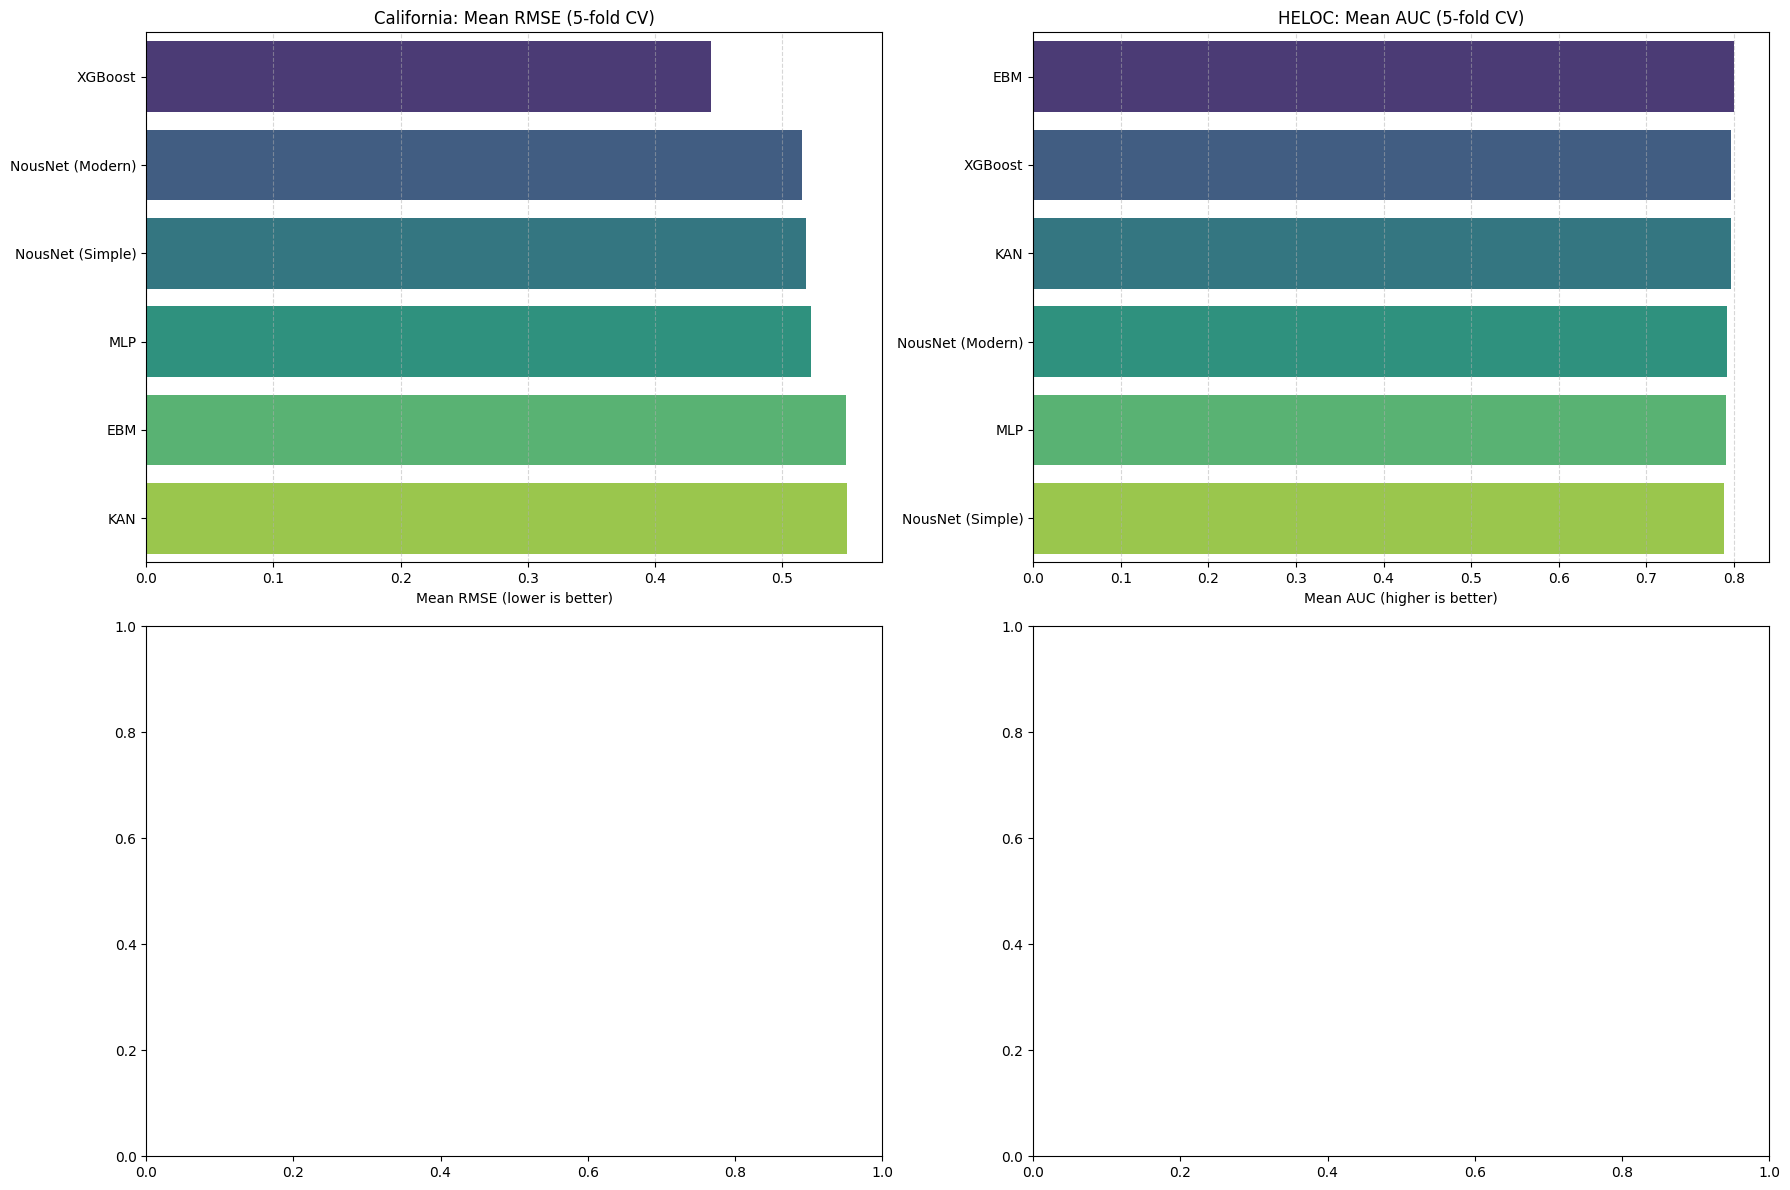

In [10]:
if not final_results_df.empty:
    summary_df = final_results_df.groupby(["dataset", "model", "metric"]).agg(
        mean=("value", "mean"), std=("value", "std"), mean_time_s=("time_s", "mean")
    ).reset_index().dropna(subset=["mean"])

    print("--- Aggregated 5-Fold Cross-Validation Results ---")
    print(summary_df.to_string(index=False, float_format="%.4f"))

    datasets = summary_df["dataset"].unique()
    metric_map = {"HELOC": "AUC", "Adult": "AUC", "BreastCancer": "AUC", "California": "RMSE"}
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.ravel()

    for i, ds_name in enumerate(datasets):
        if i >= len(axes): break
        metric_to_plot = metric_map.get(ds_name, "AUC")
        plot_data = summary_df[(summary_df.dataset == ds_name) & (summary_df.metric == metric_to_plot)]
        is_lower_better = metric_to_plot == "RMSE"
        plot_data = plot_data.sort_values("mean", ascending=is_lower_better)

        sns.barplot(data=plot_data, x="mean", y="model", ax=axes[i], orient="h", palette="viridis")
        axes[i].set_title(f"{ds_name}: Mean {metric_to_plot} (5-fold CV)")
        axes[i].set_xlabel(f"Mean {metric_to_plot}" + (" (lower is better)" if is_lower_better else " (higher is better)"))
        axes[i].set_ylabel("")
        axes[i].grid(True, axis="x", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()
else:
    print("No results to summarize or plot.")

## Interpretability Showcase (NousNet Modern)

In [11]:
def showcase_interpretability_classification(
    X: pd.DataFrame, y: pd.Series, feature_names: List[str], class_names: List[str], dataset_tag: str
):
    print("\n" + "="*80 + f"\nInterpretability Showcase: {dataset_tag} (Classification)\n" + "="*80)

    X_tr_full, X_te, y_tr_full, y_te = train_test_split(X.values, y.values, test_size=0.2, random_state=42, stratify=y.values)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr_full, y_tr_full, test_size=0.2, random_state=42, stratify=y_tr_full)

    print("Training NousNet (Modern) for interpretation...")
    modern_cfg = {
        "rule_selection_method": "soft_fact",
        "use_calibrators": True,
        "use_prototypes": True,
        "gater_name": "logistic_threshold",
        "gater_kwargs": {"tau": 0.5, "iters": 30},
    }
    optim_cfg = {"name": "radam_kl"}
    nous_model = fit_nous(X_tr, y_tr, X_val, y_val, feature_names, "classification", modern_cfg, optim_cfg)
    y_proba_nous = predict_mlp(nous_model, X_te, "classification")
    print(f"NousNet (Modern) Performance -> Accuracy: {accuracy_score(y_te, (np.argmax(y_proba_nous, axis=1) if y_proba_nous.ndim>1 else (y_proba_nous>0.5).astype(int))):.4f} | AUC: {safe_auc(y_te, y_proba_nous):.4f}")

    sample_idx = 0
    print("\n--- NousNet (Modern) Explanation for a Single Sample ---")
    print(generate_enhanced_explanation(nous_model, X_te[sample_idx], y_te[sample_idx], feature_names, class_names))
    
    pruning_threshold = select_pruning_threshold_global_bs(nous_model, X_val, target_fidelity=0.99, task_type="classification", device=DEVICE)
    print(f"\nSelected pruning threshold for 99% fidelity: {pruning_threshold:.4f}")
    print(generate_enhanced_explanation(nous_model, X_te[sample_idx], y_te[sample_idx], feature_names, class_names, use_pruning=True, pruning_threshold=pruning_threshold))

    try:
        print("\n--- Global Prototype Report (Top 5 by Count) ---")
        global_proto_report = prototype_report_global(nous_model, X_tr, y=y_tr, class_names=class_names, top_k_rules=5)
        top_protos = global_proto_report.sort_values("top1_count", ascending=False).head(5)
        print(top_protos[["proto", "primary_class", "class_entropy", "mean_activation", "top1_count"]].to_string(index=False))

        top_proto_id = int(top_protos.iloc[0]["proto"])
        print(f"\n--- Describing Top Prototype #{top_proto_id} ---")
        print(describe_prototype(nous_model, proto_id=top_proto_id, feature_names=feature_names, class_names=class_names))
    except Exception as e:
        print(f"\nPrototype analytics failed: {e}")

In [12]:
# Run interpretability for classification datasets
for name, (loader, task) in datasets_to_run.items():
    if task == "classification":
        try:
            X, y, features, class_names = loader()
            showcase_interpretability_classification(X, y, features, class_names, dataset_tag=name)
        except Exception as e:
            print(f"Could not run interpretability showcase for {name}. Error: {e}")

Loaded HELOC dataset successfully.

Interpretability Showcase: HELOC (Classification)
Training NousNet (Modern) for interpretation...
NousNet (Modern) Performance -> Accuracy: 0.7194 | AUC: 0.7902

--- NousNet (Modern) Explanation for a Single Sample ---
MODEL: SOFT_FACT rules | TASK: CLASSIFICATION
SAMPLE PREDICTION: Bad
  - Confidence: 0.822
  - Ground Truth: Bad
------------------------------------------------------------
CAUSAL RULE IMPACT (Top 5):
  • B1/R16: Δmargin=+0.077 [+] | 0.30 AND + 0.40 OR + 0.30 k-of-n
    F24 (w=0.08), F29 (w=0.07)  →  [F24] β( [L−R](x̃) = (0.99·MSinceMostRecentInqexcl7days + 0.23·NetFractionInstallBurden + 0.19·MaxDelqEver + 0.14·NumInstallTradesWBalance) − (0.26·PercentInstallTrades + 0.25·NumBank2NatlTradesWHighUtilization + 0.21·PercentTradesNeverDelq + 0.14·NumRevolvingTradesWBalance) > 0.07; k=1.13, ν=0.73 )  where x̃ are calibrated features | [F29] β( [L−R](x̃) = (0.32·NumInqLast6M + 0.27·MSinceMostRecentInqexcl7days + 0.19·NetFractionRevolvingBu